# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096-iap17/blob/master/lecture1/Boxes-and-registers.ipynb.)

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [14]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.629204 
 0.81924  
 0.998893 
 0.611558 
 0.810778 
 0.710587 
 0.493303 
 0.967814 
 0.919642 
 0.854785 
 0.0306634
 0.22942  
 0.718838 
 ⋮        
 0.462034 
 0.764417 
 0.746277 
 0.783909 
 0.703095 
 0.776156 
 0.41044  
 0.118008 
 0.969914 
 0.953944 
 0.919038 
 0.350343 

In [15]:
sum(a)   

5.000477433603909e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

Julia has a `BenchmarkTools.jl` package for easy and accurate benchmarking:

In [16]:
#Pkg.add("BenchmarkTools")

In [17]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [40]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc  -fPIC -O3 -ffast-math -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [19]:
c_sum(a)

5.000477433603959e6

In [20]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [21]:
≈  # alias for the `isapprox` function

isapprox (generic function with 3 methods)

In [22]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=sqrt(eps), atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= atol + rtol*max(norm(x), norm(y))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, `rtol` defaults to `sqrt(eps(typeof(real(x-y))))`. This corresponds to requiring equality of about half of the significand digits. For other types, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to `vecnorm` but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true
```


We can now benchmark the C code directly from Julia:

In [41]:
c_bench = @benchmark c_sum($a) 

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.684 ms (0.00% GC)
  median time:      3.942 ms (0.00% GC)
  mean time:        4.032 ms (0.00% GC)
  maximum time:     6.240 ms (0.00% GC)
  --------------
  samples:          1238
  evals/sample:     1

In [24]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 8.135431 msec


In [42]:
#d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 3 entries:
  "C"               => 3.68377
  "Python numpy"    => 3.92235
  "Python built-in" => 68.3521

In [26]:
using Plots
gr()

Plots.GRBackend()

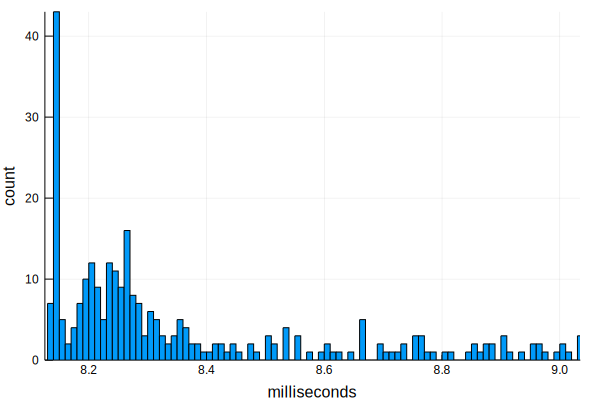

In [27]:
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [28]:
#Pkg.add("PyCall")

In [29]:
using PyCall

In [30]:
# Call a low-level PyCall function to get a Python list, because
# by default PyCall will convert to a NumPy array instead (we benchmark NumPy below):

apy_list = PyCall.array2py(a, 1, 1)

# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [31]:
pysum(a)

5.000477433603959e6

In [32]:
pysum(a) ≈ sum(a)

true

In [33]:
py_list_bench = @benchmark $pysum($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  512 bytes
  allocs estimate:  17
  --------------
  minimum time:     68.352 ms (0.00% GC)
  median time:      70.890 ms (0.00% GC)
  mean time:        72.047 ms (0.00% GC)
  maximum time:     89.635 ms (0.00% GC)
  --------------
  samples:          70
  evals/sample:     1

In [34]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 2 entries:
  "C"               => 8.13543
  "Python built-in" => 68.3521

# 3. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [35]:
using Conda 
#Conda.add("numpy")

In [36]:
numpy_sum = pyimport("numpy")["sum"]
apy_numpy = PyObject(a) # converts to a numpy array by default

py_numpy_bench = @benchmark $numpy_sum($apy_numpy)

BenchmarkTools.Trial: 
  memory estimate:  512 bytes
  allocs estimate:  17
  --------------
  minimum time:     3.922 ms (0.00% GC)
  median time:      4.385 ms (0.00% GC)
  mean time:        4.519 ms (0.00% GC)
  maximum time:     6.929 ms (0.00% GC)
  --------------
  samples:          1104
  evals/sample:     1

In [37]:
numpy_sum(apy_list) # python thing

5.000477433603904e6

In [38]:
numpy_sum(apy_list) ≈ sum(a)

true

In [39]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 8.13543
  "Python numpy"    => 3.92235
  "Python built-in" => 68.3521

# 4. Python, hand-written 

In [43]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x127a4b0c8>

In [44]:
py_hand = @benchmark $sum_py($apy_list)

BenchmarkTools.Trial: 
  memory estimate:  512 bytes
  allocs estimate:  17
  --------------
  minimum time:     449.732 ms (0.00% GC)
  median time:      454.618 ms (0.00% GC)
  mean time:        455.263 ms (0.00% GC)
  maximum time:     466.758 ms (0.00% GC)
  --------------
  samples:          11
  evals/sample:     1

In [45]:
sum_py(apy_list)

5.000477433603959e6

In [46]:
sum_py(apy_list) ≈ sum(a)

true

In [47]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"                   => 3.68377
  "Python numpy"        => 3.92235
  "Python hand-written" => 449.732
  "Python built-in"     => 68.3521

# 5. Julia (built-in) 

## Written directly in Julia, not in C!

In [48]:
@which sum(a)

sum(a) in Base at reduce.jl:359

In [49]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.737 ms (0.00% GC)
  median time:      3.767 ms (0.00% GC)
  mean time:        3.854 ms (0.00% GC)
  maximum time:     6.865 ms (0.00% GC)
  --------------
  samples:          1295
  evals/sample:     1

In [50]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 3.68377
  "Python numpy"        => 3.92235
  "Python hand-written" => 449.732
  "Python built-in"     => 68.3521
  "Julia built-in"      => 3.73699

# 6. Julia (hand-written) 

In [51]:
function mysum(A)   
    s = 0.0  # s = zero(eltype(A))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [52]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     8.137 ms (0.00% GC)
  median time:      9.094 ms (0.00% GC)
  mean time:        9.373 ms (0.00% GC)
  maximum time:     12.921 ms (0.00% GC)
  --------------
  samples:          533
  evals/sample:     1

In [53]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 3.68377
  "Python numpy"        => 3.92235
  "Julia hand-written"  => 8.13657
  "Python hand-written" => 449.732
  "Python built-in"     => 68.3521
  "Julia built-in"      => 3.73699

# Summary

In [54]:
for (key, value) in sort(collect(d))
    println(rpad(key, 20, "."), lpad(round(value, 1), 8, "."))
end

C........................3.7
Julia built-in...........3.7
Julia hand-written.......8.1
Python built-in.........68.4
Python hand-written....449.7
Python numpy.............3.9


In [55]:
for (key, value) in sort(collect(d), by=x->x[2])
    println(rpad(key, 20, "."), lpad(round(value, 2), 10, "."))
end

C.........................3.68
Julia built-in............3.74
Python numpy..............3.92
Julia hand-written........8.14
Python built-in..........68.35
Python hand-written.....449.73
